### Loading the cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")

print(quant.columns)
print(categ.columns)
print(len(categ), len(quant))
display(quant.head())
display(categ.head())

Index(['kur', 'length_ms', 'mean', 'mfcc_max', 'mfcc_mean', 'mfcc_std',
       'sc_kur', 'sc_max', 'sc_mean', 'sc_min', 'sc_skew', 'sc_std', 'skew',
       'stft_kur', 'stft_min', 'stft_skew', 'stft_std', 'zero_crossings_sum'],
      dtype='object')
Index(['vocal_channel', 'emotion', 'emotional_intensity', 'statement',
       'repetition', 'actor', 'sex'],
      dtype='object')
2452 2452


,kur,length_ms,mean,mfcc_max,mfcc_mean,mfcc_std,sc_kur,sc_max,sc_mean,sc_min,sc_skew,sc_std,skew,stft_kur,stft_min,stft_skew,stft_std,zero_crossings_sum
0,9.406061,3737,0.435115,0.295213,0.364634,0.454352,0.123738,0.766460,0.648163,0.575309,0.325936,0.551824,0.273153,0.184467,0.437367,0.568130,0.689802,16995
1,19.564187,3904,0.434904,0.511665,0.505299,0.417233,0.048477,0.476926,0.535794,0.428604,0.312511,0.766001,0.292157,0.115827,0.397277,0.522350,0.782470,13906
2,4.881241,4671,0.436059,0.254710,0.468918,0.382435,0.122017,0.479789,0.466500,0.480660,0.405462,0.553049,0.302659,0.173137,0.290466,0.595302,0.781861,18723
3,13.040259,3637,0.435047,0.414398,0.273763,0.677553,0.054609,0.494705,0.569571,0.451037,0.260804,0.769826,-0.081014,0.091015,0.316737,0.515785,0.827419,11617
4,7.485109,4404,0.435328,0.226628,0.438075,0.342806,0.115161,0.486484,0.526047,0.494780,0.430878,0.586275,0.414872,0.122901,0.343053,0.533742,0.772979,15137


,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F
1,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F
2,song,happy,strong,Dogs are sitting by the door,2nd,16.0,F
3,speech,surprised,normal,Kids are talking by the door,1st,14.0,F
4,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F


### Normalization

In [2]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
from pandas import DataFrame

scaler = StandardScaler()

X = quant.values
X = scaler.fit_transform(X)

# UMAP

In [3]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
import umap 

X = quant.values
scaler = StandardScaler()
X = scaler.fit_transform(X)
reducer = umap.UMAP(n_neighbors=100)
embedding = reducer.fit_transform(X)

In [4]:
embed_df = pd.DataFrame(dict(x=embedding[:,0], y=embedding[:,1]))
embed_cat = embed_df.join(categ)
embed_cat.head()
embed_cat

,x,y,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,5.920325,7.107831,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F
1,5.534346,7.974002,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F
2,7.598183,6.520823,song,happy,strong,Dogs are sitting by the door,2nd,16.0,F
3,4.674111,9.184541,speech,surprised,normal,Kids are talking by the door,1st,14.0,F
4,7.430712,7.098818,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F
...,...,...,...,...,...,...,...,...,...
2447,1.959146,7.489438,speech,calm,strong,Kids are talking by the door,1st,23.0,M
2448,1.737958,7.731994,speech,calm,normal,Dogs are sitting by the door,1st,23.0,M
2449,3.387679,2.242085,song,sad,strong,Dogs are sitting by the door,2nd,23.0,M
2450,2.352514,6.293294,speech,surprised,normal,Kids are talking by the door,1st,GNAA,M


Text(0, 0.5, '')

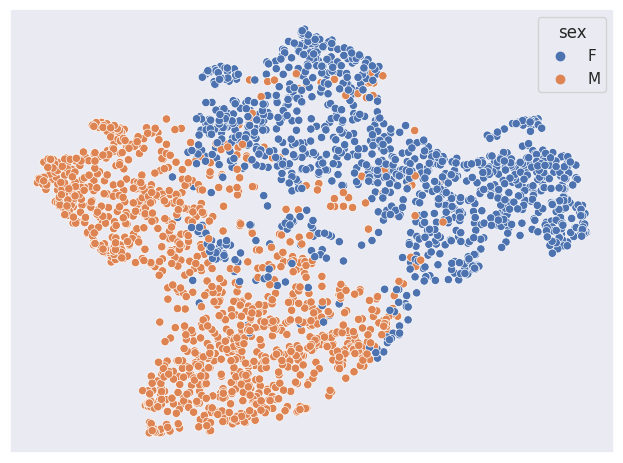

In [5]:
sns.scatterplot(data=embed_cat,x="x", y="y", hue="sex")
# plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")


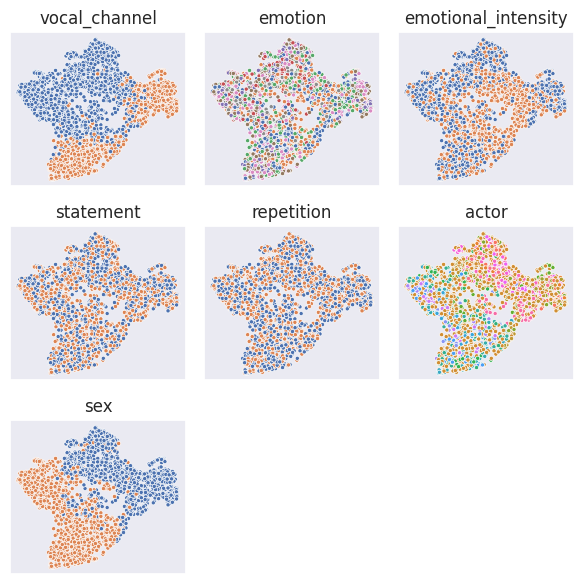

In [6]:
fig, axes = plt.subplots(3,3, figsize=(6,6))
axes=axes.flatten()

for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

for ax, cat in zip(axes, categ.columns):
    sns.scatterplot(data=embed_cat, x="x", y="y", hue=cat, marker=".", ax=ax)
    ax.axis("on")
    ax.set_title(cat)
    ax.get_legend().remove()

fig.savefig("UMAP_categ.pdf")

We drop the analysis of `repetition`, `actor` and `statement` by now

## ISOMAP and Minkowski _p_

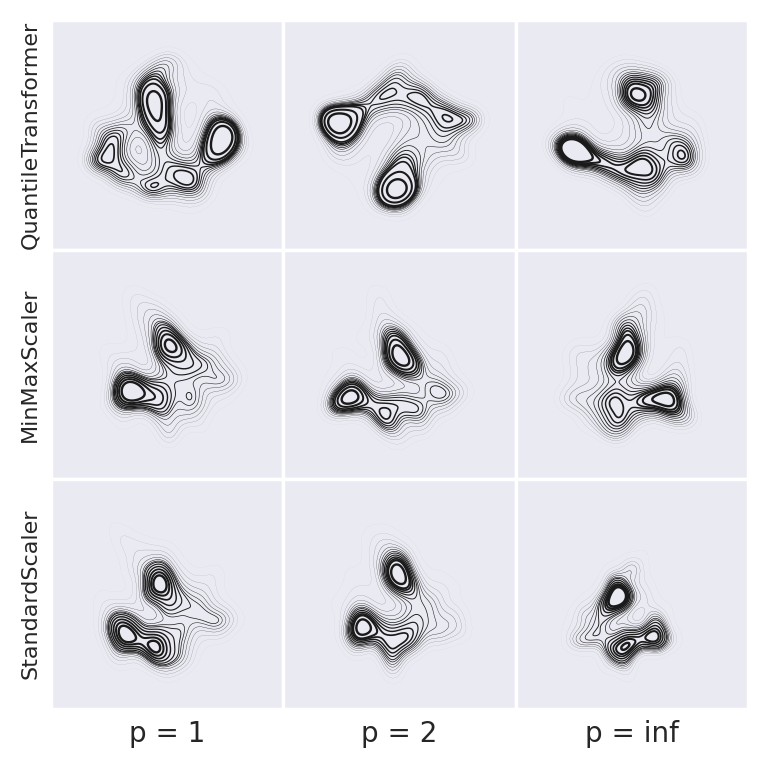

In [7]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
from sklearn.manifold import Isomap

scalers = [QuantileTransformer(), MinMaxScaler(), StandardScaler()]
ps = [1,2,np.inf]

fig, axes = plt.subplots(len(scalers),len(ps), figsize=(4,4),gridspec_kw = {'wspace':0, 'hspace':0}, dpi=200)

for i, scaler in enumerate(scalers):
    for j, p in enumerate(ps):
        X = quant.values
        X = scaler.fit_transform(X)
        S = Isomap(n_neighbors=3, p=p).fit_transform(X)
        sns.kdeplot(x=S[:,0], y=S[:,1], ax=axes[i,j], color="k", levels=np.linspace(0,1,15), linewidths=np.linspace(0,1,15)**2)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        
        if j == 0:
            axes[i,j].set_ylabel(str(scaler.__class__).split(".")[-1][:-2], font={"size":8})
        if i==2:
            axes[i,j].set_xlabel(f"p = {p}", font={"size":10})
        # axes[i,j].axis("off")
plt.savefig("isomap_tests.png")
plt.show()

In [8]:
X = QuantileTransformer().fit_transform(quant.values)
S = Isomap(n_neighbors=3, p=1).fit_transform(X)

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'marker'
  cset = contour_func(


<AxesSubplot: >

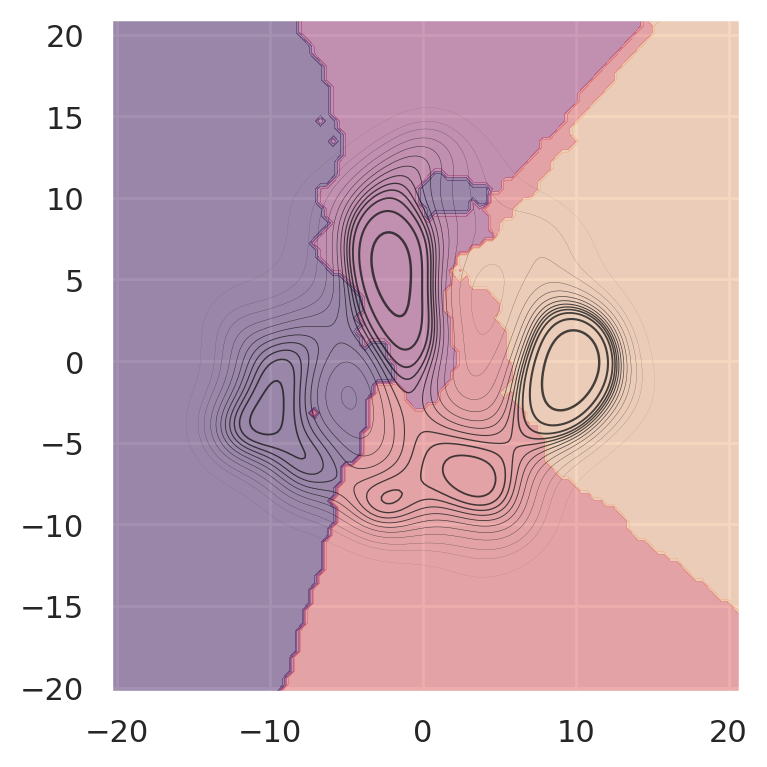

In [9]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.cm import get_cmap
fig, ax = plt.subplots(figsize=(4,4),dpi=200)
cmap= get_cmap("flare", 4)
classes = [f"{s} - {v}" for v, s in zip(categ.vocal_channel, categ.sex)]
classifier = KNeighborsClassifier(n_neighbors=23).fit(S, classes)
dbd = DecisionBoundaryDisplay.from_estimator(classifier, S, response_method="predict", alpha=0.5, ax=ax, eps=6, cmap = cmap)

sns.kdeplot(x=S[:,0], y=S[:,1], marker=".", color="k", linestyles="-", linewidths=np.linspace(0.1,1,15)**2, fill=False, alpha=0.8, levels=np.linspace(0,1,15), ax=ax)
# sns.scatterplot(x=S[:,0], y=S[:,1], marker=".", s=100,hue=classes, ax=ax, palette="flare", zorder=10)

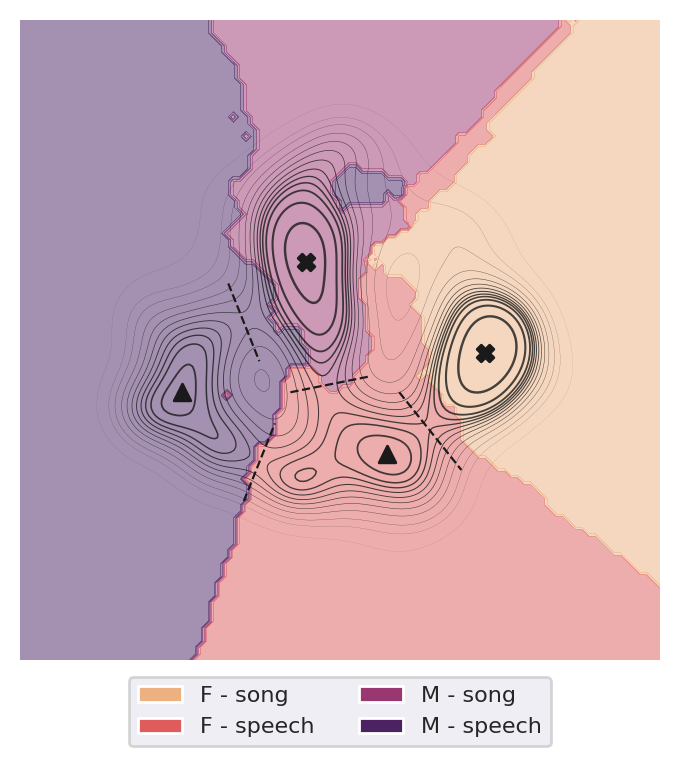

In [10]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
unique_classes = np.unique(classes)
legend_elements = [Patch(facecolor=cmap(0), label=unique_classes[0]),
                     Patch(facecolor=cmap(1), label=unique_classes[1]),
                     Patch(facecolor=cmap(2), label=unique_classes[2]),
                     Patch(facecolor=cmap(3), label=unique_classes[3])]

ax.legend(handles=legend_elements, loc='center', fontsize=8, bbox_to_anchor=(0.5, -0.08), ncols=2)
centers = np.array([[-2,5.4], [9.5, -0.5]]).T
ax.scatter(centers[0], centers[1], marker="X", color="k")

centers = np.array([[-10,-3], [3.2, -7]]).T
ax.scatter(centers[0], centers[1], marker="^", color="k")

lines = [ [[-6, -4], [-10, -5]], 
          [[4,   8], [-3,  -8]], 
          [[-7, -5], [4,    -1]],
          [[-3,  2], [-3,   -2]]
          ]

for line in lines:
    ax.plot(line[0], line[1], ls="--", color="k", lw=0.8)

ax.axis("off")
ax.set_aspect("equal")
fig.tight_layout()
display(fig)
fig.savefig("isomap_kde.png")